# Настройка среды

In [5]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [3]:
%pip install --upgrade pip
%pip install optuna
%pip install belashovplot

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas
import optuna
from random import random, randint
import numpy
import torch
from typing import Callable
from tqdm import tqdm
from belashovplot import TiledPlot
from parameters import FigureWidthHeight, FontLibrary
from utilities import upper_integer
from math import sqrt
from itertools import product
import matplotlib.pyplot as plt

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (10, 10)

# Импорты и загрузка бызы исследований

In [17]:
study = optuna.create_study(study_name="ID2NN Fixed", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)

[I 2024-05-06 00:34:41,243] Using an existing study with name 'ID2NN Fixed' instead of creating a new one.


In [18]:
# Не запускать при работе optuna!!!!
trials = [trial for trial in study.trials if trial.values != None]
if len(trials) != len(study.trials):
    optuna.delete_study(study_name="ID2NN Fixed", storage="sqlite:///ID2NN.db")
    study = optuna.create_study(study_name="ID2NN Fixed", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)
    study.add_trials(trials)

[I 2024-05-06 00:34:42,417] A new study created in RDB with name: ID2NN Fixed


In [19]:
print(f"Кол-во исследований: {len(study.trials)}")
dataframe:pandas.DataFrame = study.trials_dataframe()

Кол-во исследований: 74


In [20]:
dataframe.nlargest(5, 'value')

,number,value,datetime_start,datetime_complete,duration,params_batch size,params_cross entorpy proportion,params_distance,params_learning rate,params_masks amount,params_optimizer type,state
13,13,24.23,2024-05-05 19:41:54.857915,2024-05-05 19:51:27.692056,0 days 00:09:32.834141,20,0.012893,0.120469,0.012239,5,Adam,COMPLETE
50,50,24.23,2024-05-05 19:41:54.857915,2024-05-05 19:51:27.692056,0 days 00:09:32.834141,20,0.012893,0.120469,0.012239,5,Adam,COMPLETE
14,14,22.75,2024-05-05 19:51:27.708051,2024-05-05 20:01:09.985477,0 days 00:09:42.277426,26,0.210195,0.113952,0.008646,5,Adam,COMPLETE
51,51,22.75,2024-05-05 19:51:27.708051,2024-05-05 20:01:09.985477,0 days 00:09:42.277426,26,0.210195,0.113952,0.008646,5,Adam,COMPLETE
33,33,21.90,2024-05-05 23:34:20.744926,2024-05-05 23:42:43.298982,0 days 00:08:22.554056,26,0.415645,0.147875,0.000980,4,Adam,COMPLETE


In [21]:
dataframe[dataframe['value'] >= 29].nlargest(5, 'params_distance')

,number,value,datetime_start,datetime_complete,duration,params_batch size,params_cross entorpy proportion,params_distance,params_learning rate,params_masks amount,params_optimizer type,state


# Векторизация данных

In [22]:
target_key = 'value'
target_type = dataframe.dtypes['value']
parameters_keys = [key for key in dataframe.keys() if key.startswith('params_')]
parameters_types = [dataframe.dtypes[key] for key in parameters_keys]

def vectorize(values:list):
    unique = set(dataframe[pkey])
    object_map = dict(zip(unique, numpy.linspace(0, 1, len(unique))))
    array = [object_map[value] for value in dataframe[pkey].values]
    return array

vectors = torch.zeros((len(parameters_keys), len(dataframe)), dtype=torch.float32, requires_grad=False)
for i, (pkey, ptype) in enumerate(zip(parameters_keys, parameters_types)):
    if ptype == 'object': array = vectorize(dataframe[pkey].values)
    else:                 array = dataframe[pkey].values
    vectors[i] = torch.tensor(array)
vectors = vectors.swapdims(0,1)
vectors_maxs, _ = torch.max(vectors, dim=0, keepdim=True)
vectors_mins, _ = torch.min(vectors, dim=0, keepdim=True)
normalized_vectors = (vectors - vectors_mins) / (vectors_maxs - vectors_mins)
if target_type == 'object': array = vectorize(dataframe[target_key].values)
else:                       array = dataframe[target_key].values
targets = torch.tensor(array, dtype=torch.float32)
target_name = target_key
vector_names = [key[len('params_'):] for key in parameters_keys]

# Проекции

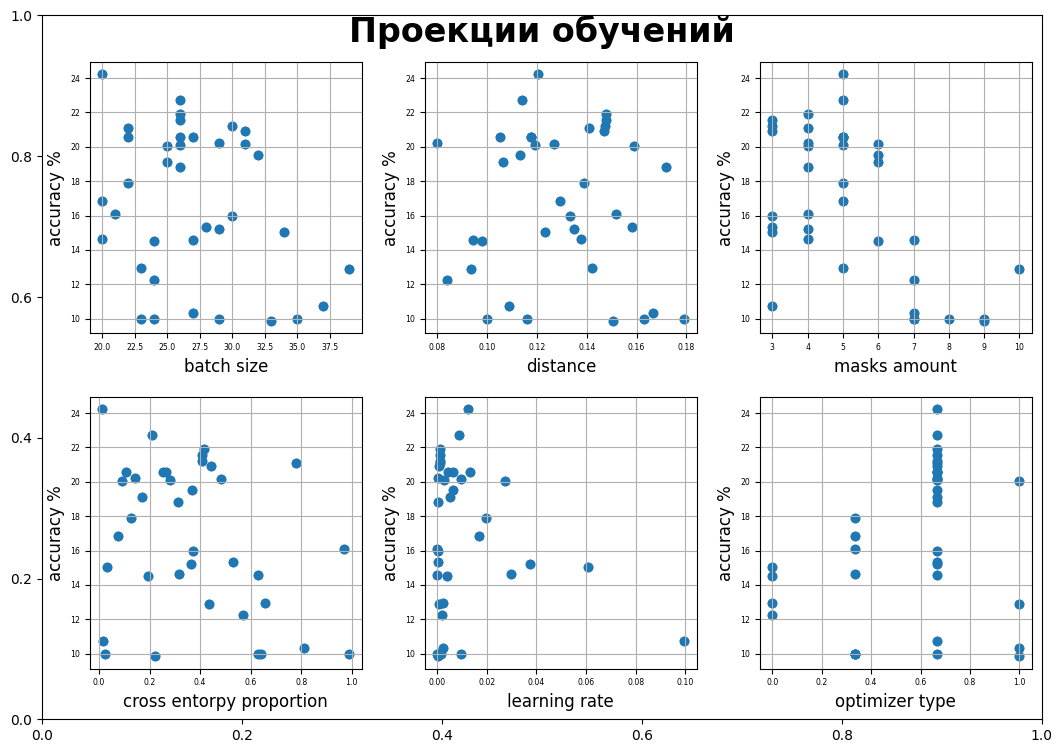

In [23]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title(f"Проекции обучений")
plot.pad.graph.horizontal(0.2)
plot.pad.graph.vertical(0.2)

cols = upper_integer(sqrt(vectors.shape[1]))
rows = upper_integer(vectors.shape[1]/cols)
colrow = product(range(cols), range(rows))

for (col, row), (x_num, x_name) in zip(colrow, enumerate(vector_names)):
    axes = plot.axes.add(col,row)
    axes.grid(True)
    axes.scatter(vectors[:,x_num].clone().detach(), targets.clone().detach())
    plot.graph.label.x(x_name)
    plot.graph.label.y('accuracy %')

plot.show()

# Функция оптимизация случайной проекции

In [9]:
def optimize_projection_2d(vectors:torch.Tensor, targets:torch.Tensor, minimization:Callable[[torch.Tensor,torch.Tensor],torch.Tensor]):
    vectors = vectors.requires_grad_(True)
    targets = targets.requires_grad_(True)
    rate = 1.0E-4
    with torch.enable_grad():
        parameters = torch.nn.Parameter(torch.normal(0., 0.1, (vectors.shape[1], 2)))
        # parameters = torch.nn.Parameter(torch.ones((vectors.shape[1], 2)))
        # print('parameters:', list(torch.abs(parameters).flatten().clone().detach().numpy()))

        loss = minimization(torch.matmul(vectors, torch.abs(parameters)), targets)
        loss.backward()
        prev_loss = loss.item()
        prev_grad = parameters.grad.clone().detach()

        # print('prev_grad:', list(prev_grad.flatten().clone().detach().numpy()))
        while rate > 1.0E-16 and prev_loss != 0:
            with torch.no_grad():
                random_values = torch.normal(0., 0.01, (vectors.shape[1], 2))
            loss = minimization(torch.matmul(vectors, torch.abs(random_values)), targets)
            with torch.no_grad():
                if loss.item() < prev_loss:
                    rate *= 1.5
                    parameters = parameters.copy_(random_values)
                    with torch.enable_grad():
                        loss = minimization(torch.matmul(vectors, torch.abs(parameters)), targets)
                    prev_loss = loss.item()
                    loss.backward()
                    prev_grad = parameters.grad.clone().detach()
                    parameters.grad.zero_()
                    continue
            
            with torch.no_grad():
                random_shift = torch.normal(0., 0.01, (vectors.shape[1], 2))
                parameters.copy_(parameters + random_shift)
            loss = minimization(torch.matmul(vectors, torch.abs(parameters)), targets)
            with torch.no_grad():
                if loss.item() >= prev_loss:
                    parameters.copy_(parameters - random_shift)
                else:
                    rate *= 1.5
                    prev_loss = loss.item()
                    loss.backward()
                    prev_grad = parameters.grad.clone().detach()
                    parameters.grad.zero_()
                    continue
            
            with torch.no_grad():
                parameters.copy_(parameters - rate*prev_grad)
            loss = minimization(torch.matmul(vectors, torch.abs(parameters)), targets)
            with torch.no_grad():
                if loss.item() >= prev_loss:
                    parameters.copy_(parameters + rate*prev_grad)
                    rate /= 2.0
                    continue
                else:
                    # print('parameters:', list(torch.abs(parameters).flatten().clone().detach().numpy()))
                    rate *= 1.3242135
                    prev_loss = loss.item()
                    loss.backward()
                    prev_grad = parameters.grad.clone().detach()
                    # print('prev_grad:', list(prev_grad.flatten().clone().detach().numpy()))
                    parameters.grad.zero_()
    return torch.matmul(vectors, torch.abs(parameters)).clone().detach(), torch.abs(parameters).clone().detach()

# Равномерное распределение

In [10]:
def uniform_(projection:torch.Tensor, targets:torch.Tensor):
    x_mesh, y_mesh = projection[:,0].view(1,-1), projection[:,1].view(1,-1)
    dR2 = (x_mesh - x_mesh.T)**2 + (y_mesh - y_mesh.T)**2
    mask = dR2 != 0
    dR2 = torch.where(mask, dR2, 1.0E-8)
    dR = torch.sqrt(dR2)
    phis = torch.mean(torch.where(mask, 1/dR, 0), dim=1)
    mean_phi = torch.mean(phis)
    result = torch.mean((phis - mean_phi)**2)
    return result

_uniform_n = 40
def uniform(projection:torch.Tensor, targets:torch.Tensor):
    x_array = torch.linspace(projection[:,0].min(), projection[:,0].max(), _uniform_n)
    y_array = torch.linspace(projection[:,1].min(), projection[:,1].max(), _uniform_n)
    coordinates = torch.stack(torch.meshgrid(x_array, y_array, indexing='ij')).reshape(2, -1).swapdims(0,1)
    dX = coordinates[:,0].view(1,-1) - projection[:,0].view(1,-1).T
    dY = coordinates[:,1].view(1,-1) - projection[:,1].view(1,-1).T
    
    dR2 = dX**2 + dY**2
    mask = dR2 != 0
    dR2 = torch.where(mask, dR2, 1.0E-8)
    dR = torch.sqrt(dR2)
    phis = torch.mean(1.0 / (1.0 + dR), dim=0)
    # phis = torch.mean(torch.where(mask, 1/dR, 0), dim=0)
    mean_phi = torch.mean(phis)

    # deltas = torch.abs(phis - mean_phi)*2
    deltas = torch.log10(torch.abs(phis - mean_phi) + 1.0)
    result = torch.max(deltas)
    return result

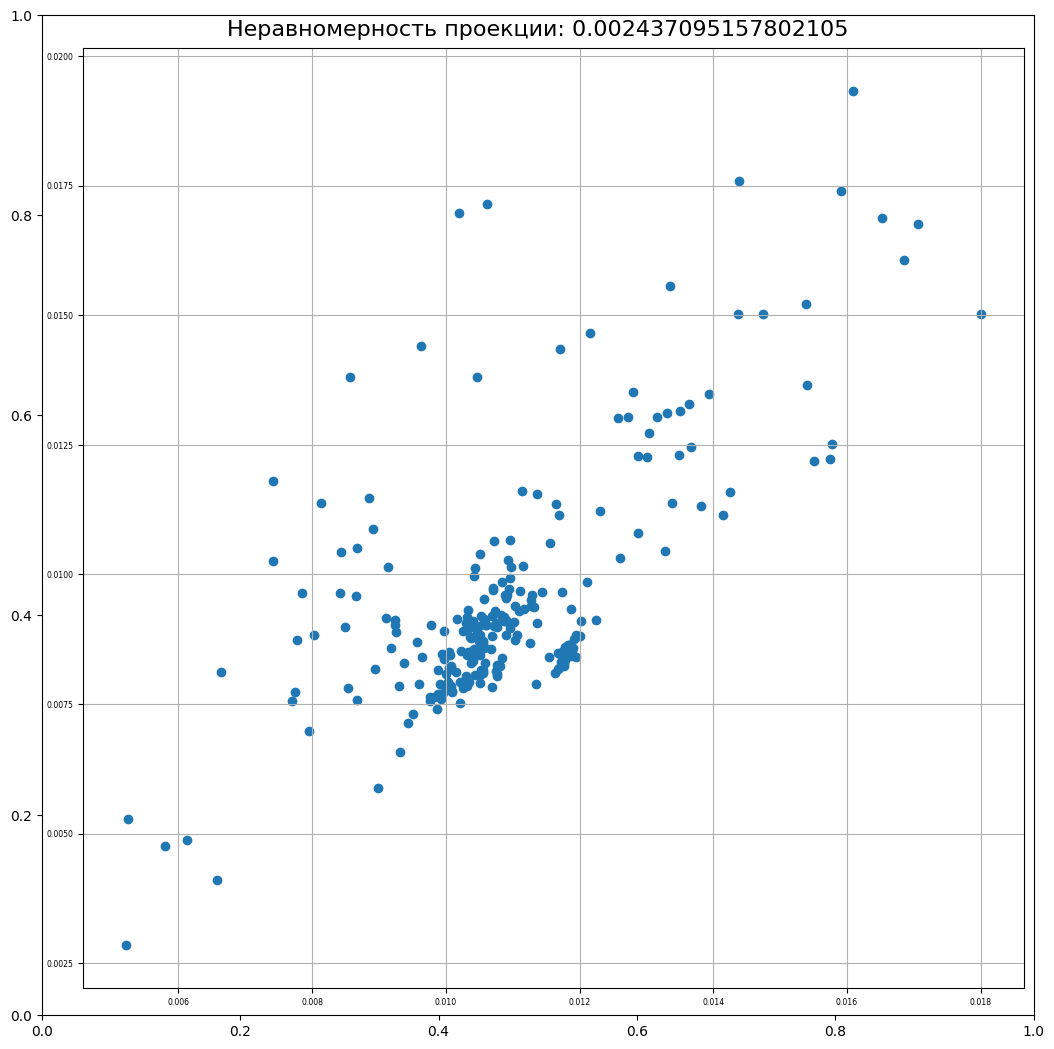

In [11]:
projection, matrix = optimize_projection_2d(normalized_vectors, targets, uniform)
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.description.top(f"Неравномерность проекции: {uniform(projection, targets)}")
axes = plot.axes.add(0,0)
axes.grid(True)
axes.scatter(projection[:,0], projection[:,1])
plot.show()

# Энкодер

In [12]:
def train(model:torch.nn.Module, optimizer:torch.optim.Optimizer, minimization:Callable[[torch.Tensor],torch.Tensor], vectors:torch.Tensor, iterations:int=1000):
    with torch.enable_grad():
        model.train()
        iterator = tqdm(range(iterations))
        for i in iterator:
            optimizer.zero_grad()
            result = model.forward(vectors)
            loss = minimization(result)
            loss.backward()
            optimizer.step()
            iterator.set_description(f"Loss ({i+1}): {loss.item()}")
        encoder.eval()

# Тренировка интерполятора

In [13]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(vectors.shape[1], 256*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.BatchNorm1d(256*vectors.shape[1]),
    torch.nn.Linear(256*vectors.shape[1], 256*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.BatchNorm1d(256*vectors.shape[1]),
    torch.nn.Linear(256*vectors.shape[1], 256*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.BatchNorm1d(256*vectors.shape[1]),
    torch.nn.Linear(256*vectors.shape[1], 2),
)
interpolator = torch.nn.Sequential(
    torch.nn.Linear(2, 512*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 512*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 512*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 128*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(128*vectors.shape[1], 1),
    torch.nn.Sigmoid(),
)
encode_interpolate = torch.nn.Sequential(encoder, interpolator)
def interpolator_loss(accuracy:torch.Tensor):
    return torch.mean((100*accuracy.squeeze() - targets)**2)
optimizer = torch.optim.Adam(interpolator.parameters(), lr=1.0E-4)
train(encode_interpolate, optimizer, interpolator_loss, normalized_vectors, 1000)

Loss (1000): nan: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:28<00:00,  3.72it/s]


### Тренировка декодера

In [84]:
decoder = torch.nn.Sequential(
    torch.nn.Linear(2, 512*vectors.shape[1]),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 512*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.BatchNorm1d(512*vectors.shape[1]),
    torch.nn.Linear(512*vectors.shape[1], 512*vectors.shape[1]),
    torch.nn.Sigmoid(),
    torch.nn.Linear(512*vectors.shape[1], vectors.shape[1]),
    torch.nn.Sigmoid(),
)
def decoder_loss(vectors_:torch.Tensor):
    return torch.nn.functional.mse_loss(normalized_vectors, vectors_)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1.0E-5)
train(decoder, optimizer, decoder_loss, encoder.forward(normalized_vectors).clone().detach(), 500)

Loss (500): 0.09665428847074509: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.16it/s]


## Визуализация

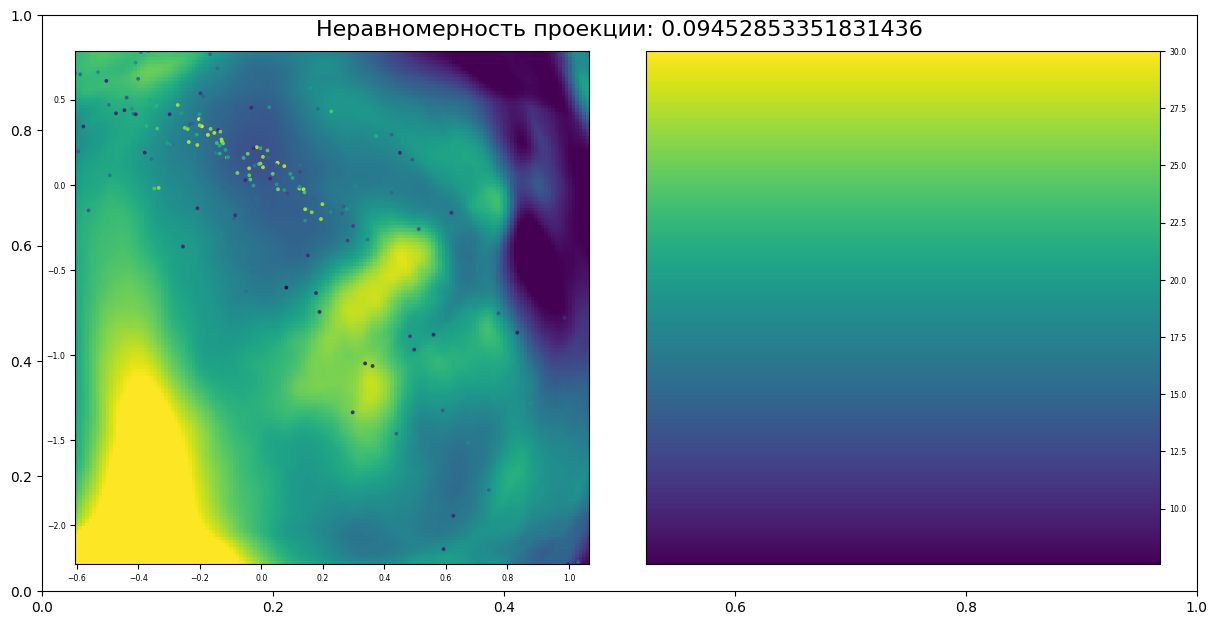

In [85]:
with torch.no_grad():
    projection = encoder.forward(normalized_vectors)
    plot = TiledPlot(*FigureWidthHeight)
    plot.FontLibrary = FontLibrary
    plot.description.top(f"Неравномерность проекции: {uniform(projection, targets)}")
    axes = plot.axes.add(0,0)
    scatter = axes.scatter(projection[:,0], projection[:,1], c=targets, s=3)

    N = 150
    x_array = torch.linspace(projection[:,0].min(), projection[:,0].max(), N)
    y_array = torch.linspace(projection[:,1].min(), projection[:,1].max(), N)
    coordinates = torch.stack(torch.meshgrid(x_array, y_array, indexing='ij')).reshape(2, -1).swapdims(0,1)
    accuracy = 100*interpolator.forward(coordinates)
    image = axes.imshow(accuracy.reshape(N, N), aspect='auto', extent=[x_array[0], x_array[-1], y_array[0], y_array[-1]], vmin=targets.min(), vmax=targets.max())

    axes = plot.axes.add(1, 0)
    plt.colorbar(image, cax=axes)
    # plt.colorbar(scatter, cax=axes)
    
    plot.show()